<a href="https://colab.research.google.com/github/Sebasu11/WiDS-2022/blob/main/WIDS2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WiDS Datathon 2022

**Background**

Climate change is a globally relevant, urgent, and multi-faceted issue heavily impacted by energy policy and infrastructure. Addressing climate change involves mitigation (i.e. mitigating greenhouse gas emissions) and adaptation (i.e. preparing for unavoidable consequences). Mitigation of GHG emissions requires changes to electricity systems, transportation, buildings, industry, and land use.

According to a report issued by the International Energy Agency (IEA), the lifecycle of buildings from construction to demolition were responsible for 37% of global energy-related and process-related CO2 emissions in 2020. Yet it is possible to drastically reduce the energy consumption of buildings by a combination of easy-to-implement fixes and state-of-the-art strategies. For example, retrofitted buildings can reduce heating and cooling energy requirements by 50-90 percent. Many of these energy efficiency measures also result in overall cost savings and yield other benefits, such as cleaner air for occupants. This potential can be achieved while maintaining the services that buildings provide.

## Overview: the dataset and challenge
The WiDS Datathon dataset was created in collaboration with Climate Change AI (CCAI) and Lawrence Berkeley National Laboratory (Berkeley Lab). WiDS Datathon participants will analyze differences in building energy efficiency, creating models to **predict building energy consumption**. Participants will use a dataset consisting of variables that describe building characteristics and climate and weather variables for the regions in which the buildings are located. Accurate predictions of energy consumption can help policymakers target retrofitting efforts to maximize emissions reductions.

# Evaluation Metric

The evaluation metric for this competition is Root Mean Squared Error (RMSE). The RMSE is commonly used measure of the differences between predicted values provided by a model and the actual observed values.

## libraries

In [1]:
!pip install scikit-lego -q
!pip install catboost -q
!pip install plotly -q
!pip install Boruta -q
!pip install ipywidgets -q
!jupyter nbextension enable --py widgetsnbextension -q

     |████████████████████████████████| 223 kB 26.0 MB/s 
     |████████████████████████████████| 86 kB 3.6 MB/s 
     |████████████████████████████████| 1.1 MB 47.8 MB/s 
     |████████████████████████████████| 76.1 MB 1.2 MB/s 
     |████████████████████████████████| 56 kB 3.3 MB/s 
Enable an nbextension in frontend configuration.

Usage
    jupyter nbextension enable [--system|--sys-prefix]

Options
-------

Arguments that take values are actually convenience aliases to full
Configurables, whose aliases are listed on the help line. For more information
on full configurables, see '--help-all'.

--python
    Install from a Python package
--sys-prefix
    Use sys.prefix as the prefix for installing nbextensions (for environments, packaging)
--user
    Apply the operation only for the given user
--debug
    set log level to logging.DEBUG (maximize logging output)
--py
    Install from a Python package
--system
    Apply the operation system-wide
--section=<Unicode> (ToggleNBExtensionApp

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [3]:
pd.options.display.max_columns = 100

# Load Data

## Data Dictionary
### Covariates
**id**: building id

**Year_Factor**: anonymized year in which the weather and energy usage factors were observed

**State_Factor**: anonymized state in which the building is located

**building_class**: building classification

**facility_type**: building usage type

**floor_area**: floor area (in square feet) of the building

**year_built**: year in which the building was constructed

**energy_star_rating**: the energy star rating of the building

**ELEVATION**: elevation of the building location

**january_min_temp**: minimum temperature in January (in Fahrenheit) at the location of the building

**january_avg_temp**: average temperature in January (in Fahrenheit) at the location of the building

**january_max_temp**: maximum temperature in January (in Fahrenheit) at the location of the building

**cooling_degree_days**: cooling degree day for a given day is the number of degrees where the daily average temperature exceeds 65 degrees Fahrenheit. Each month is summed to produce an annual total at the location of the building.

**heating_degree_days**: heating degree day for a given day is the number of degrees where the daily average temperature falls under 65 degrees Fahrenheit. Each month is summed to produce an annual total at the location of the building.

**precipitation_inches**: annual precipitation in inches at the location of the building

**snowfall_inches**: annual snowfall in inches at the location of the building

**snowdepth_inches**: annual snow depth in inches at the location of the building

**avg_temp**: average temperature over a year at the location of the building

**days_below_30F**: total number of days below 30 degrees Fahrenheit at the location of the building

**days_below_20F**: total number of days below 20 degrees Fahrenheit at the location of the building

**days_below_10F**: total number of days below 10 degrees Fahrenheit at the location of the building

**days_below_0F**: total number of days below 0 degrees Fahrenheit at the location of the building

**days_above_80F**: total number of days above 80 degrees Fahrenheit at the location of the building

**days_above_90F**: total number of days above 90 degrees Fahrenheit at the location of the building

**days_above_100F**: total number of days above 100 degrees Fahrenheit at the location of the building

**days_above_110F**: total number of days above 110 degrees Fahrenheit at the location of the building

**direction_max_wind_speed**: wind direction for maximum wind speed at the location of the building. Given in 360-degree compass point directions (e.g. 360 = north, 180 = south, etc.).

**direction_peak_wind_speed**: wind direction for peak wind gust speed at the location of the building. Given in 360-degree compass point directions (e.g. 360 = north, 180 = south, etc.).

**max_wind_speed**: maximum wind speed at the location of the building

**days_with_fog**: number of days with fog at the location of the building

**TARGET**
site_eui: Site Energy Usage Intensity is the amount of heat and electricity consumed by a building as reflected in utility bills

In [4]:
from IPython.display import display_html
def display_side_by_side(*args):
    """
    Display DataFrames Side by Side
    input : Dataframes output: None
    """
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [5]:
train = pd.read_csv("drive/MyDrive/WIDS/train.csv")
test = pd.read_csv("drive/MyDrive/WIDS/test.csv")


In [6]:
train.columns =  [col.lower() for col in train.columns]
train         = train[["id","site_eui"]+[col for col in train.columns if col not in ["id","site_eui"]]]
print("train Shape",train.shape)

train Shape (26279, 64)


In [7]:
test.columns =  [col.lower() for col in test.columns]
test = test[train.drop("site_eui",axis=1).columns]
test.shape

(9705, 63)

### Info

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26279 entries, 0 to 26278
Data columns (total 64 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         26278 non-null  float64
 1   site_eui                   26278 non-null  float64
 2   year_factor                26279 non-null  int64  
 3   state_factor               26279 non-null  object 
 4   building_class             26279 non-null  object 
 5   facility_type              26279 non-null  object 
 6   floor_area                 26279 non-null  float64
 7   year_built                 24835 non-null  float64
 8   energy_star_rating         13808 non-null  float64
 9   elevation                  26279 non-null  float64
 10  january_min_temp           26279 non-null  int64  
 11  january_avg_temp           26279 non-null  float64
 12  january_max_temp           26279 non-null  int64  
 13  february_min_temp          26279 non-null  int

### Target : site_eui

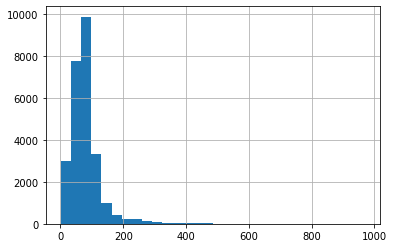

In [9]:
train["site_eui"].hist(bins=30);

In [10]:
train["site_eui"].describe(percentiles=[0.01,0.1,0.25,0.5,0.75,0.9,0.99]).to_frame()

,site_eui
count,26278.000000
mean,81.084662
std,60.616571
min,1.003281
1%,6.823675
10%,31.133734
25%,52.558435
50%,72.031123
75%,93.612029
90%,124.628011


### Year Factor

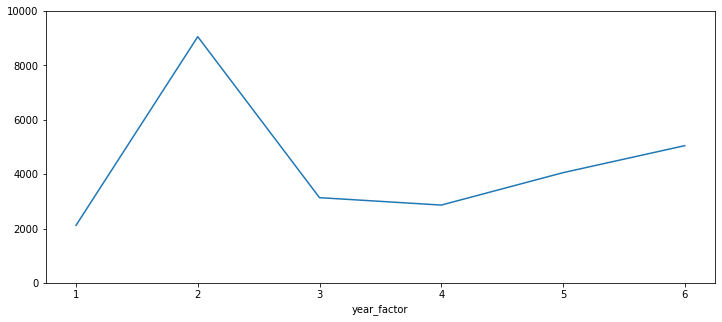

In [11]:
train.groupby(["year_factor"])["id"].count().plot(kind="line",figsize=(12,5),ylim=[0,10000]);

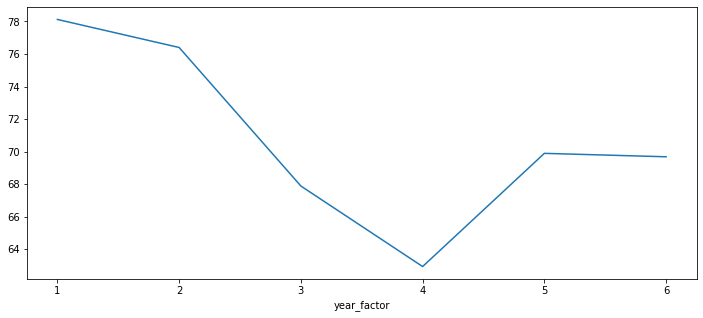

In [12]:
train.groupby(["year_factor"])["site_eui"].median().plot(kind="line",figsize=(12,5));

In [13]:
test["year_factor"].value_counts()

7    9705
Name: year_factor, dtype: int64

### state_factor

In [14]:
train["state_factor"].value_counts()

State_6    11490
State_1     5618
State_2     4871
State_4     4300
Name: state_factor, dtype: int64

In [15]:
train.pivot_table(values="id",
                  columns="state_factor",
                  index="year_factor",
                  aggfunc='count',
                  fill_value=None,
                  margins=False,
                  dropna=True,
                  margins_name='All',
                  observed=False)

state_factor,State_1,State_2,State_4,State_6
year_factor,,,,
1,358.0,13.0,NaN,1746.0
2,680.0,14.0,NaN,8364.0
3,1242.0,515.0,NaN,1379.0
4,1261.0,1370.0,232.0,NaN
5,1041.0,1558.0,1456.0,NaN
6,1036.0,1401.0,2612.0,NaN


In [16]:
train.pivot_table(values="site_eui",
                  columns="state_factor",
                  index="year_factor",
                  aggfunc='mean',
                  fill_value=None,
                  margins=False,
                  dropna=True,
                  margins_name='All',
                  observed=False)

state_factor,State_1,State_2,State_4,State_6
year_factor,,,,
1,70.148330,81.831620,NaN,98.764624
2,66.543553,94.532905,NaN,84.003879
3,60.261259,80.064677,NaN,85.273355
4,58.362694,78.439699,109.719905,NaN
5,63.259263,77.675325,100.612697,NaN
6,62.512324,76.533208,90.891978,NaN


In [17]:
test.pivot_table(values="id",
                  columns="state_factor",
                  index="year_factor",
                  aggfunc='count',
                  fill_value=None,
                  margins=False,
                  dropna=True,
                  margins_name='All',
                  observed=False)

state_factor,State_1,State_10,State_11,State_2,State_4,State_8
year_factor,,,,,,
7,1027,4,3268,1515,2568,1323


### building_class

In [18]:
train["building_class"].value_counts(1)

Commercial     0.56235
Residential    0.43765
Name: building_class, dtype: float64

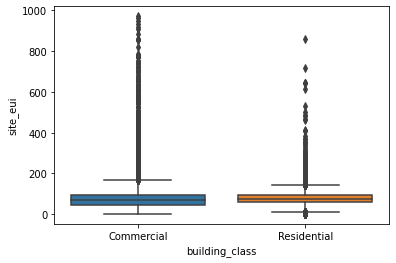

In [19]:
sns.boxplot(data=train,x="building_class",y="site_eui")

In [20]:
test["building_class"].value_counts(1)

Commercial     0.577743
Residential    0.422257
Name: building_class, dtype: float64

### facility_type

In [21]:
train["facility_type"].nunique(),test["facility_type"].nunique()

(58, 60)

In [22]:
(test
 .loc[lambda d:~d["facility_type"].isin(train["facility_type"].unique())]
 )["facility_type"].value_counts()

2to4_Unit_Building         966
Warehouse_Uncategorized    157
Name: facility_type, dtype: int64

In [23]:
train.groupby(["state_factor"]).agg(facility_quantity=("facility_type",lambda x:x.nunique()))

,facility_quantity
state_factor,
State_1,43
State_2,46
State_4,37
State_6,41


In [24]:
display_side_by_side(train["facility_type"].value_counts(1).to_frame(),
                     test["facility_type"].value_counts(1).to_frame()
                     )

,facility_type
Multifamily_Uncategorized,0.421325
Office_Uncategorized,0.253054
Education_Other_classroom,0.050725
Lodging_Hotel,0.042429
Education_Uncategorized,0.025343
Retail_Uncategorized,0.020549
Commercial_Other,0.020435
Education_College_or_university,0.019065
Warehouse_Nonrefrigerated,0.016591
Nursing_Home,0.010350


In [25]:
(train
 .groupby(["facility_type"])["site_eui"]
 .describe()
 .sort_values("count",ascending=False)
 .style.background_gradient(subset="50%")
 )

,count,mean,std,min,25%,50%,75%,max
facility_type,,,,,,,,
Multifamily_Uncategorized,11072.000000,78.278541,34.998689,1.003281,60.723879,76.024712,92.153718,857.546216
Office_Uncategorized,6650.000000,72.087622,46.246772,1.543437,49.424172,65.529551,84.811616,970.388586
Education_Other_classroom,1333.000000,74.654773,44.871261,3.511355,57.785063,70.536285,85.650179,819.081003
Lodging_Hotel,1115.000000,99.446575,47.719361,2.991803,68.265403,91.647403,118.823720,672.590110
Education_Uncategorized,666.000000,43.152283,47.264901,3.637533,24.636027,32.922051,47.614082,910.563198
Retail_Uncategorized,540.000000,75.786223,58.174976,6.301046,41.962771,63.717293,94.360245,492.679076
Commercial_Other,537.000000,92.721936,111.502687,1.196721,33.700000,62.467556,104.790234,948.758564
Education_College_or_university,501.000000,101.213169,92.233555,3.171200,59.246933,82.532474,115.748661,933.427176
Warehouse_Nonrefrigerated,436.000000,32.430766,34.831879,1.299171,11.368852,23.435378,43.766150,496.403079


### floor_area

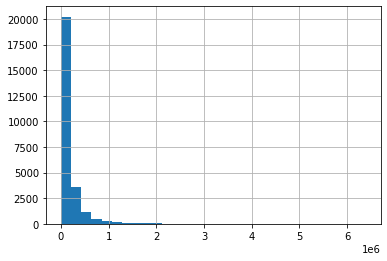

In [26]:
train["floor_area"].hist(bins=30);

In [27]:
train[["floor_area","site_eui"]].corr()

,floor_area,site_eui
floor_area,1.000000,0.073425
site_eui,0.073425,1.000000


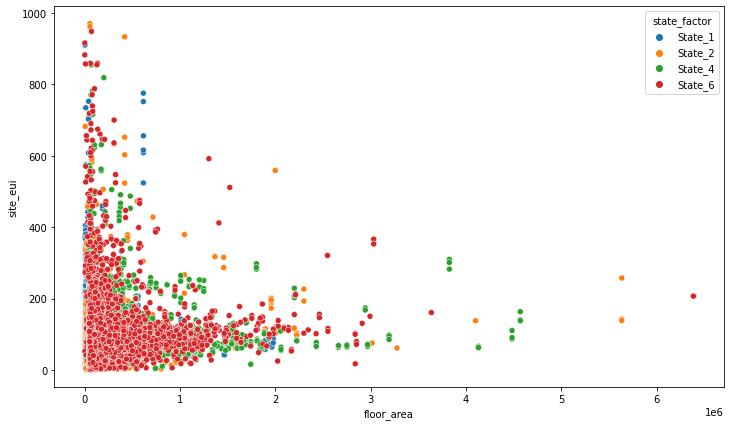

In [28]:
plt.figure(figsize=(12,7))
sns.scatterplot(data=train,x="floor_area",y="site_eui",hue="state_factor");

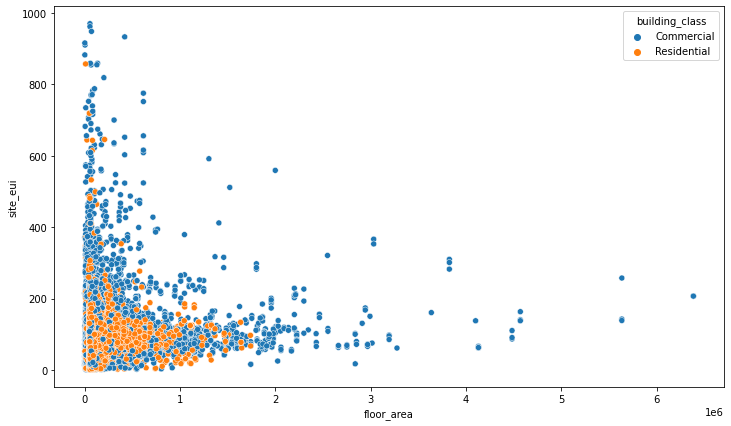

In [29]:
plt.figure(figsize=(12,7))
sns.scatterplot(data=train,x="floor_area",y="site_eui",hue="building_class")

### year_built

In [30]:
train["year_built"].nunique()

162

In [31]:
train["year_built"].describe()

count    24835.000000
mean      1952.311737
std         44.995261
min          0.000000
25%       1926.000000
50%       1954.000000
75%       1980.000000
max       2015.000000
Name: year_built, dtype: float64

In [32]:
train[["year_built","site_eui"]].corr()

,year_built,site_eui
year_built,1.000000,0.054578
site_eui,0.054578,1.000000


In [33]:
test["year_built"].nunique()

164

In [34]:
test["year_built"].describe()

count    9613.000000
mean     1963.219598
std        40.819953
min         0.000000
25%      1929.000000
50%      1969.000000
75%      1994.000000
max      2016.000000
Name: year_built, dtype: float64

### energy_star_rating

In [35]:
display_side_by_side(train["energy_star_rating"].describe(percentiles=[0.01,0.1,0.25,0.5,0.75,0.9,0.99]).to_frame(),
                     test["energy_star_rating"].describe(percentiles=[0.01,0.1,0.25,0.5,0.75,0.9,0.99]).to_frame()
                     )

,energy_star_rating
count,13808.000000
mean,63.758184
std,27.606818
min,0.000000
1%,1.000000
10%,20.000000
25%,44.000000
50%,71.000000
75%,86.000000
90%,95.000000


In [36]:
train[["energy_star_rating","site_eui"]].corr()

,energy_star_rating,site_eui
energy_star_rating,1.000000,-0.493603
site_eui,-0.493603,1.000000


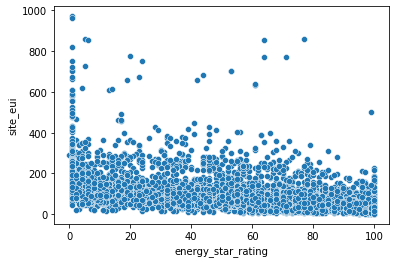

In [37]:
sns.scatterplot(data=train,#.loc[lambda d:d["site_eui"]<400],
                x="energy_star_rating",y="site_eui")

In [38]:
train["energy_star_rating"].value_counts()

100.0    417
91.0     280
90.0     276
89.0     271
82.0     271
        ... 
13.0      58
8.0       57
10.0      49
5.0       48
0.0        1
Name: energy_star_rating, Length: 101, dtype: int64

### elevation

In [39]:
display_side_by_side(train["elevation"].describe(percentiles=[0.01,0.1,0.25,0.5,0.75,0.9,0.99]).to_frame(),
                     test["elevation"].describe(percentiles=[0.01,0.1,0.25,0.5,0.75,0.9,0.99]).to_frame()
                     )

,elevation
count,26279.000000
mean,61.668587
std,87.214326
min,-6.400000
1%,2.400000
10%,3.000000
25%,9.100000
50%,42.700000
75%,52.700000
90%,201.800000


In [40]:
train[["elevation","site_eui"]].corr()

,elevation,site_eui
elevation,1.000000,0.040913
site_eui,0.040913,1.000000


### Year Temp

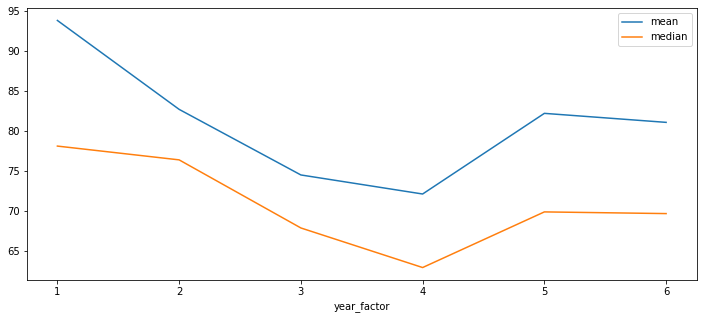

In [41]:
(
train.groupby(["year_factor"])
.agg(
     #min=("site_eui","min"),
     mean=("site_eui","mean"),
     median=("site_eui","median")
    )
.plot(kind="line",figsize=(12,5))
);

In [42]:
yearly_temp = train.columns[10:46]
yearly_temp

Index(['january_min_temp', 'january_avg_temp', 'january_max_temp',
       'february_min_temp', 'february_avg_temp', 'february_max_temp',
       'march_min_temp', 'march_avg_temp', 'march_max_temp', 'april_min_temp',
       'april_avg_temp', 'april_max_temp', 'may_min_temp', 'may_avg_temp',
       'may_max_temp', 'june_min_temp', 'june_avg_temp', 'june_max_temp',
       'july_min_temp', 'july_avg_temp', 'july_max_temp', 'august_min_temp',
       'august_avg_temp', 'august_max_temp', 'september_min_temp',
       'september_avg_temp', 'september_max_temp', 'october_min_temp',
       'october_avg_temp', 'october_max_temp', 'november_min_temp',
       'november_avg_temp', 'november_max_temp', 'december_min_temp',
       'december_avg_temp', 'december_max_temp'],
      dtype='object')

In [ ]:
# TODO PLOT temp 

In [ ]:
train.sample(10)

,id,site_eui,year_factor,state_factor,building_class,facility_type,floor_area,year_built,energy_star_rating,elevation,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30f,days_below_20f,days_below_10f,days_below_0f,days_above_80f,days_above_90f,days_above_100f,days_above_110f,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog
24165,24165.0,84.195709,2,State_6,Residential,Multifamily_Uncategorized,138039.0,1960.0,NaN,3.4,13,37.322581,62,20,40.879310,62,25,50.935484,78,38,54.766667,88.0,49.0,65.096774,89.0,51.0,70.983333,94.0,61.0,78.758065,100.0,61.0,76.693548,91.0,53.0,68.800000,91.0,38.0,58.048387,78.0,31.0,43.866667,66.0,28.0,41.467742,62.0,1277.0,3978.0,38.51,9.6,10.0,57.366120,22.0,5.0,0.0,0.0,72.0,17.0,0.0,0.0,1.0,1.0,1.0,56.0
12964,12964.0,93.961498,6,State_4,Commercial,Retail_Enclosed_mall,95204.0,2008.0,NaN,205.7,-2,25.166667,50,2,29.711538,65,12,44.516129,73,23,49.017241,88.0,38.0,61.933333,94.0,42.0,73.400000,97.0,54.0,77.451613,96.0,54.0,77.887097,98.0,48.0,70.931034,96.0,34.0,57.758065,83.0,20.0,47.116667,76.0,-9.0,24.629032,54.0,1390.0,5436.0,42.89,27.3,154.0,53.562674,92.0,42.0,19.0,6.0,113.0,40.0,0.0,0.0,NaN,NaN,NaN,267.0
15340,15340.0,89.548183,1,State_6,Commercial,Office_Uncategorized,57585.0,1904.0,60.0,42.7,6,29.677419,53,15,36.035714,67,20,42.322581,77,35,54.300000,83.0,46.0,64.483871,89.0,56.0,72.316667,95.0,63.0,80.241935,104.0,59.0,75.274194,94.0,51.0,70.033333,86.0,33.0,57.096774,84.0,36.0,51.883333,70.0,22.0,43.306452,62.0,1331.0,4335.0,72.81,44.7,418.0,56.519178,54.0,11.0,1.0,0.0,84.0,16.0,1.0,0.0,1.0,1.0,1.0,12.0
11012,11012.0,80.771966,5,State_4,Commercial,Education_Other_classroom,86191.0,1896.0,32.0,212.4,-8,21.935484,46,-13,15.696429,44,0,34.161290,72,27,48.200000,78.0,35.0,60.241935,86.0,41.0,65.366667,91.0,51.0,70.677419,94.0,50.0,71.564516,94.0,46.0,68.866667,93.0,29.0,54.064516,78.0,12.0,44.733333,73.0,15.0,39.693548,62.0,769.0,6226.0,41.75,44.8,426.0,49.800000,96.0,53.0,31.0,15.0,64.0,8.0,0.0,0.0,NaN,NaN,NaN,NaN
17696,17696.0,74.190454,2,State_6,Residential,Multifamily_Uncategorized,73975.0,1980.0,NaN,15.2,13,37.322581,62,20,40.879310,62,25,50.935484,78,38,54.766667,88.0,49.0,65.096774,89.0,51.0,70.983333,94.0,61.0,78.758065,100.0,61.0,76.693548,91.0,53.0,68.800000,91.0,38.0,58.048387,78.0,31.0,43.866667,66.0,28.0,41.467742,62.0,1277.0,3978.0,38.51,9.6,10.0,57.366120,22.0,5.0,0.0,0.0,72.0,17.0,0.0,0.0,NaN,NaN,NaN,NaN
25178,25178.0,75.933823,3,State_6,Commercial,Office_Uncategorized,76214.0,1998.0,NaN,11.9,11,35.080645,61,17,33.910714,55,27,40.145161,59,33,52.983333,82.0,42.0,62.790323,90.0,53.0,72.650000,92.0,64.0,79.838710,98.0,59.0,74.596774,90.0,47.0,67.866667,96.0,40.0,60.193548,86.0,23.0,45.250000,70.0,19.0,38.548387,71.0,1272.0,4670.0,46.32,29.6,64.0,55.449315,50.0,11.0,0.0,0.0,75.0,11.0,0.0,0.0,NaN,NaN,NaN,NaN
7135,7135.0,13.714904,4,State_2,Commercial,Warehouse_Nonrefrigerated,101989.0,2009.0,31.0,44.2,3,28.290323,59,13,34.107143,68,7,37.951613,70,31,54.450000,84.0,44.0,65.034483,90.0,54.0,74.483333,95.0,55.0,76.033333,97.0,55.0,73.550000,89.0,46.0,69.172414,93.0,38.0,59.183333,81.0,19.0,43.357143,72.0,23.0,40.350000,72.0,1170.0,4760.0,53.09,31.6,39.0,54.651685,88.0,26.0,12.0,0.0,93.0,17.0,0.0,0.0,NaN,NaN,NaN,NaN
1626,1626.0,91.981096,3,State_1,Commercial,Office_Uncategorized,17760.0,1969.0,29.0,62.5,26,44.516129,64,30,4

## Missing

In [ ]:
train.isnull().mean().sort_values(ascending=False).head(20)

direction_peak_wind_speed    0.628867
direction_max_wind_speed     0.627421
max_wind_speed               0.627421
days_with_fog                0.570075
energy_star_rating           0.474561
year_built                   0.054949
july_min_temp                0.000038
september_max_temp           0.000038
september_avg_temp           0.000038
september_min_temp           0.000038
august_max_temp              0.000038
august_avg_temp              0.000038
july_max_temp                0.000038
july_avg_temp                0.000038
june_avg_temp                0.000038
june_max_temp                0.000038
october_avg_temp             0.000038
june_min_temp                0.000038
may_max_temp                 0.000038
may_avg_temp                 0.000038
dtype: float64

# PipeLine

In [ ]:
def start_pipe(dataframe):
  return dataframe.copy()


def dropna_target(dataframe):
  dataframe = dataframe.dropna(subset=["site_eui"])
  return dataframe
  
def new_features(dataframe):
  dataframe["antique"]=2022-dataframe["year_built"]
  dataframe["year_state"]=dataframe["year_factor"].astype("str")+"_"+dataframe["state_factor"]
  dataframe["number_building_year_state"]=dataframe.groupby(["year_state"])["id"].transform("count")
  dataframe["year_state_facility"]=dataframe["year_factor"].astype("str")+"_"+dataframe["state_factor"]+"_"+dataframe["facility_type"]
  dataframe["number_building_year_state_facility"]=dataframe.groupby(["year_state_facility"])["id"].transform("count")

  return dataframe

#def lag_features()

def drop_columns(dataframe):
  dataframe = dataframe.drop(columns=["id","direction_peak_wind_speed","direction_max_wind_speed",
                                      "max_wind_speed","days_with_fog","energy_star_rating"
                                      ])
  return dataframe


In [ ]:
%%time
print("pipeline Train")
train_clean = (train.pipe(start_pipe)
                    .pipe(dropna_target)
                    .pipe(new_features)
                    .pipe(drop_columns)
              )
print(f"train_clean shape : ",train_clean.shape)
print("pipeline Test")
test_clean = (test.pipe(start_pipe)
                  .pipe(new_features)
                  .pipe(drop_columns)
              )
print(f"test_clean shape : ",test_clean.shape)

pipeline Train
train_clean shape :  (26278, 63)
pipeline Test
test_clean shape :  (9705, 62)
CPU times: user 124 ms, sys: 25.1 ms, total: 149 ms
Wall time: 149 ms


# ML

## RandomForest

In [ ]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from boruta import BorutaPy

In [ ]:
X = train_clean.drop("site_eui",axis=1)
y = train_clean["site_eui"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [ ]:
numeric_features = X.select_dtypes("number").columns.tolist()
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),
           ]
           )

categorical_features = ['state_factor', 'building_class', 'facility_type']
categorical_transformer = Pipeline(
  steps=[("encoder", OrdinalEncoder(handle_unknown="use_encoded_value",unknown_value=-999)),
           ]
           )

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

prep = Pipeline(steps=[("preprocessor", preprocessor)])

In [ ]:
X_train_trans = prep.fit_transform(X_train)
X_test_trans  = prep.transform(X_test)

In [ ]:
X_train[numeric_features+categorical_features].head()

,year_factor,floor_area,year_built,elevation,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30f,days_below_20f,days_below_10f,days_below_0f,days_above_80f,days_above_90f,days_above_100f,days_above_110f,antique,building_state_year,state_factor,building_class,facility_type
15767,1,99932.0,1902.0,42.7,6,29.677419,53,15,36.035714,67,20,42.322581,77,35,54.300000,83.0,46.0,64.483871,89.0,56.0,72.316667,95.0,63.0,80.241935,104.0,59.0,75.274194,94.0,51.0,70.033333,86.0,33.0,57.096774,84.0,36.0,51.883333,70.0,22.0,43.306452,62.0,1331.0,4335.0,72.81,44.7,418.0,56.519178,54.0,11.0,1.0,0.0,84.0,16.0,1.0,0.0,120.0,1746,State_6,Commercial,Office_Uncategorized
23800,2,170000.0,1962.0,3.4,13,37.322581,62,20,40.879310,62,25,50.935484,78,38,54.766667,88.0,49.0,65.096774,89.0,51.0,70.983333,94.0,61.0,78.758065,100.0,61.0,76.693548,91.0,53.0,68.800000,91.0,38.0,58.048387,78.0,31.0,43.866667,66.0,28.0,41.467742,62.0,1277.0,3978.0,38.51,9.6,10.0,57.366120,22.0,5.0,0.0,0.0,72.0,17.0,0.0,0.0,60.0,8364,State_6,Commercial,Warehouse_Nonrefrigerated
10059,6,154807.0,1980.0,3.0,11,32.000000,62,10,35.907407,67,26,49.693548,82,28,54.870370,85.0,41.0,61.750000,91.0,51.0,74.293103,95.0,63.0,79.903226,100.0,61.0,79.550000,100.0,52.0,73.275862,95.0,35.0,60.053571,86.0,26.0,47.879310,80.0,14.0,39.033333,68.0,1570.0,4138.0,37.12,30.0,62.0,57.443182,69.0,24.0,0.0,0.0,109.0,38.0,0.0,0.0,42.0,1401,State_2,Commercial,Office_Uncategorized
1358,3,91619.0,1914.0,45.7,26,44.516129,64,30,49.392857,69,37,55.967742,77,40,61.783333,90.0,45.0,65.129032,91.0,52.0,70.016667,104.0,52.0,71.387097,102.0,54.0,71.322581,97.0,47.0,69.133333,98.0,43.0,61.000000,84.0,36.0,55.116667,77.0,24.0,45.387097,68.0,826.0,2542.0,4.50,0.0,0.0,60.056164,20.0,0.0,0.0,0.0,111.0,31.0,5.0,0.0,108.0,1242,State_1,Residential,Mixed_Use_Predominantly_Commercial
18464,2,265091.0,1980.0,15.2,13,37.322581,62,20,40.879310,62,25,50.935484,78,38,54.766667,88.0,49.0,65.096774,89.0,51.0,70.983333,94.0,61.0,78.758065,100.0,61.0,76.693548,91.0,53.0,68.800000,91.0,38.0,58.048387,78.0,31.0,43.866667,66.0,28.0,41.467742,62.0,1277.0,3978.0,38.51,9.6,10.0,57.366120,22.0,5.0,0.0,0.0,72.0,17.0,0.0,0.0,42.0,8364,State_6,Commercial,Office_Uncategorized


In [ ]:
pd.DataFrame(X_train_trans,columns=numeric_features+categorical_features).head()

,year_factor,floor_area,year_built,elevation,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30f,days_below_20f,days_below_10f,days_below_0f,days_above_80f,days_above_90f,days_above_100f,days_above_110f,antique,building_state_year,state_factor,building_class,facility_type
0,1.0,99932.0,1902.0,42.7,6.0,29.677419,53.0,15.0,36.035714,67.0,20.0,42.322581,77.0,35.0,54.300000,83.0,46.0,64.483871,89.0,56.0,72.316667,95.0,63.0,80.241935,104.0,59.0,75.274194,94.0,51.0,70.033333,86.0,33.0,57.096774,84.0,36.0,51.883333,70.0,22.0,43.306452,62.0,1331.0,4335.0,72.81,44.7,418.0,56.519178,54.0,11.0,1.0,0.0,84.0,16.0,1.0,0.0,120.0,1746.0,3.0,0.0,31.0
1,2.0,170000.0,1962.0,3.4,13.0,37.322581,62.0,20.0,40.879310,62.0,25.0,50.935484,78.0,38.0,54.766667,88.0,49.0,65.096774,89.0,51.0,70.983333,94.0,61.0,78.758065,100.0,61.0,76.693548,91.0,53.0,68.800000,91.0,38.0,58.048387,78.0,31.0,43.866667,66.0,28.0,41.467742,62.0,1277.0,3978.0,38.51,9.6,10.0,57.366120,22.0,5.0,0.0,0.0,72.0,17.0,0.0,0.0,60.0,8364.0,3.0,0.0,55.0
2,6.0,154807.0,1980.0,3.0,11.0,32.000000,62.0,10.0,35.907407,67.0,26.0,49.693548,82.0,28.0,54.870370,85.0,41.0,61.750000,91.0,51.0,74.293103,95.0,63.0,79.903226,100.0,61.0,79.550000,100.0,52.0,73.275862,95.0,35.0,60.053571,86.0,26.0,47.879310,80.0,14.0,39.033333,68.0,1570.0,4138.0,37.12,30.0,62.0,57.443182,69.0,24.0,0.0,0.0,109.0,38.0,0.0,0.0,42.0,1401.0,1.0,0.0,31.0
3,3.0,91619.0,1914.0,45.7,26.0,44.516129,64.0,30.0,49.392857,69.0,37.0,55.967742,77.0,40.0,61.783333,90.0,45.0,65.129032,91.0,52.0,70.016667,104.0,52.0,71.387097,102.0,54.0,71.322581,97.0,47.0,69.133333,98.0,43.0,61.000000,84.0,36.0,55.116667,77.0,24.0,45.387097,68.0,826.0,2542.0,4.50,0.0,0.0,60.056164,20.0,0.0,0.0,0.0,111.0,31.0,5.0,0.0,108.0,1242.0,0.0,1.0,24.0
4,2.0,265091.0,1980.0,15.2,13.0,37.322581,62.0,20.0,40.879310,62.0,25.0,50.935484,78.0,38.0,54.766667,88.0,49.0,65.096774,89.0,51.0,70.983333,94.0,61.0,78.758065,100.0,61.0,76.693548,91.0,53.0,68.800000,91.0,38.0,58.048387,78.0,31.0,43.866667,66.0,28.0,41.467742,62.0,1277.0,3978.0,38.51,9.6,10.0,57.366120,22.0,5.0,0.0,0.0,72.0,17.0,0.0,0.0,42.0,8364.0,3.0,0.0,31.0


In [ ]:
rf = RandomForestRegressor(n_estimators=300,
                           criterion='squared_error',
                           max_depth=None,
                           min_samples_split=2,
                           min_samples_leaf=30,
                           min_weight_fraction_leaf=0.0,
                           max_features='auto',
                           max_leaf_nodes=None,
                           min_impurity_decrease=0.0,
                           bootstrap=True,
                           oob_score=False,
                           n_jobs=6,
                           random_state=42,
                           ccp_alpha=0.0,
                           max_samples=None)

In [ ]:
%%time
rf.fit(X_train_trans,y_train)

CPU times: user 58.7 s, sys: 102 ms, total: 58.8 s
Wall time: 30.3 s


RandomForestRegressor(min_samples_leaf=30, n_estimators=300, n_jobs=6,
                      random_state=42)

In [ ]:
y_pred = rf.predict(X_test_trans)
mean_squared_error(y_test,y_pred,squared=False)

54.077567094393466

In [ ]:
pd.Series(rf.feature_importances_,index=numeric_features+categorical_features).sort_values(ascending=False)

facility_type                          0.452851
number_building_year_state_facility    0.156111
floor_area                             0.084192
year_built                             0.050025
antique                                0.049869
state_factor                           0.032857
elevation                              0.018454
january_min_temp                       0.014436
march_min_temp                         0.014180
january_avg_temp                       0.013780
snowdepth_inches                       0.011071
april_avg_temp                         0.009999
precipitation_inches                   0.008837
february_max_temp                      0.008599
snowfall_inches                        0.008039
december_max_temp                      0.005998
november_avg_temp                      0.004647
building_class                         0.004341
avg_temp                               0.003311
march_avg_temp                         0.003011
june_avg_temp                          0

#### Boruta

In [ ]:
rf = RandomForestRegressor(n_estimators=150,
                           criterion='squared_error',
                           max_depth=5,
                           min_samples_split=2,
                           min_samples_leaf=30,
                           min_weight_fraction_leaf=0.0,
                           max_features='auto',
                           max_leaf_nodes=None,
                           min_impurity_decrease=0.0,
                           bootstrap=True,
                           oob_score=False,
                           n_jobs=5,
                           random_state=42,
                           ccp_alpha=0.0,
                           max_samples=None)

In [ ]:
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42)

In [ ]:
X_boruta = X_train_trans.copy()
y_boruta = y_train.ravel()

In [ ]:
%%time 
feat_selector.fit(X_boruta, y_boruta)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	58
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	14
Tentative: 	11
Rejected: 	33
Iteration: 	9 / 100
Confirmed: 	14
Tentative: 	11
Rejected: 	33
Iteration: 	10 / 100
Confirmed: 	14
Tentative: 	11
Rejected: 	33
Iteration: 	11 / 100
Confirmed: 	14
Tentative: 	11
Rejected: 	33
Iteration: 	12 / 100
Confirmed: 	15
Tentative: 	8
Rejected: 	35
Iteration: 	13 / 100
Confirmed: 	15
Tentative: 	8
Rejected: 	35
Iteration: 	14 / 100
Confirmed: 	15
Tentative: 	8
Rejected: 	35
Iteration: 	15 / 100
Confirmed: 	15
Tentative: 	8
Rejected: 	35
Iteration: 	16 / 100
Confirmed: 	15
Tentative: 	8
Re

BorutaPy(estimator=RandomForestRegressor(max_depth=5, min_samples_leaf=30,
                                         n_estimators=132, n_jobs=5,
                                         random_state=RandomState(MT19937) at 0x7FF7D5BA65A0),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7FF7D5BA65A0, verbose=2)

In [ ]:
boruta_dict = {"Features":numeric_features+categorical_features,
               "Ranking":feat_selector.ranking_,
               "Support":feat_selector.support_}

pd.DataFrame(boruta_dict).sort_values("Ranking")

,Features,Ranking,Support
57,facility_type,1,True
39,december_max_temp,1,True
42,precipitation_inches,1,True
44,snowdepth_inches,1,True
14,april_avg_temp,1,True
10,march_min_temp,1,True
9,february_max_temp,1,True
56,building_class,1,True
55,state_factor,1,True
5,january_avg_temp,1,True


In [ ]:
X_train[['facility_type', 'precipitation_inches',
       'snowdepth_inches', 
        'building_class', 'state_factor',
       'floor_area',  'elevation',
       'antique', 'year_built', 'snowfall_inches',]].sample(10)

,facility_type,precipitation_inches,snowdepth_inches,building_class,state_factor,floor_area,elevation,antique,year_built,snowfall_inches
51,Office_Uncategorized,16.59,0.0,Commercial,State_1,94000.0,59.1,34.0,1988.0,0.0
23014,Multifamily_Uncategorized,38.51,10.0,Residential,State_6,115360.0,42.7,57.0,1965.0,9.6
7272,Multifamily_Uncategorized,53.09,39.0,Residential,State_2,98174.0,3.0,10.0,2012.0,31.6
14779,Lodging_Dormitory_or_fraternity_sorority,42.89,154.0,Commercial,State_4,80742.0,198.1,52.0,1970.0,27.3
16862,Multifamily_Uncategorized,38.51,10.0,Residential,State_6,116660.0,42.7,112.0,1910.0,9.6
10213,Commercial_Unknown,37.12,62.0,Commercial,State_2,68203.0,32.9,NaN,NaN,30.0
13941,Mixed_Use_Commercial_and_Residential,42.89,154.0,Residential,State_4,462140.0,219.8,31.0,1991.0,27.3
6901,Office_Uncategorized,53.09,39.0,Commercial,State_2,95981.0,100.6,64.0,1958.0,31.6
19009,Multifamily_Uncategorized,38.51,10.0,Residential,State_6,183177.0,42.7,91.0,1931.0,9.6
19670,Multifamily_Uncategorized,38.51,10.0,Residential,State_6,52206.0,42.7,108.0,1914.0,9.6


In [ ]:
numeric_features = sorted(['precipitation_inches','snowdepth_inches','floor_area',  'elevation','antique', 'year_built', 'snowfall_inches'])
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")),
           ]
           )

categorical_features = sorted(['state_factor', 'facility_type', 'building_class'])
categorical_transformer = Pipeline(
  steps=[("encoder", OrdinalEncoder(handle_unknown="use_encoded_value",unknown_value=-999)),
           ]
           )

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

prep = Pipeline(steps=[("preprocessor", preprocessor)])

In [ ]:
X_train_tran2 = prep.fit_transform(X_train)
X_test_tran2  = prep.transform(X_test)

In [ ]:
rf = RandomForestRegressor(n_estimators=300,
                           criterion='squared_error',
                           max_depth=None,
                           min_samples_split=2,
                           min_samples_leaf=10,
                           min_weight_fraction_leaf=0.0,
                           max_features='auto',
                           max_leaf_nodes=None,
                           min_impurity_decrease=0.0,
                           bootstrap=True,
                           oob_score=False,
                           n_jobs=5,
                           random_state=42,
                           ccp_alpha=0.0,
                           max_samples=None)

In [ ]:
%%time
rf.fit(X_train_tran2,y_train)

CPU times: user 23.1 s, sys: 73.4 ms, total: 23.2 s
Wall time: 12.1 s


RandomForestRegressor(min_samples_leaf=10, n_estimators=300, n_jobs=5,
                      random_state=42)

In [ ]:
y_pred = rf.predict(X_test_tran2)
mean_squared_error(y_test,y_pred,squared=False)

51.5088117705997

## CATBOOST

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
from catboost import CatBoostRegressor, EShapCalcType, EFeaturesSelectionAlgorithm
from catboost import Pool

In [ ]:
X_train.sample(3)

,year_factor,state_factor,building_class,facility_type,floor_area,year_built,elevation,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30f,days_below_20f,days_below_10f,days_below_0f,days_above_80f,days_above_90f,days_above_100f,days_above_110f,antique
12896,6,State_4,Residential,Multifamily_Uncategorized,287705.0,2008.0,205.7,-2,25.166667,50,2,29.711538,65,12,44.516129,73,23,49.017241,88.0,38.0,61.933333,94.0,42.0,73.400000,97.0,54.0,77.451613,96.0,54.0,77.887097,98.0,48.0,70.931034,96.0,34.0,57.758065,83.0,20.0,47.116667,76.0,-9.0,24.629032,54.0,1390.0,5436.0,42.89,27.3,154.0,53.562674,92.0,42.0,19.0,6.0,113.0,40.0,0.0,0.0,14.0
7977,5,State_2,Commercial,Office_Uncategorized,260252.0,2009.0,44.2,8,29.966667,49,2,25.018519,64,9,38.448276,74,32,55.379310,81.0,47.0,69.706897,90.0,56.0,75.034483,95.0,61.0,77.500000,95.0,59.0,75.816667,94.0,51.0,72.448276,94.0,32.0,55.767857,80.0,29.0,51.339286,81.0,26.0,48.850000,72.0,1451.0,4337.0,43.61,14.8,12.0,56.427954,74.0,29.0,14.0,0.0,113.0,22.0,0.0,0.0,13.0
23225,2,State_6,Residential,Multifamily_Uncategorized,75000.0,1946.0,42.7,13,37.322581,62,20,40.879310,62,25,50.935484,78,38,54.766667,88.0,49.0,65.096774,89.0,51.0,70.983333,94.0,61.0,78.758065,100.0,61.0,76.693548,91.0,53.0,68.800000,91.0,38.0,58.048387,78.0,31.0,43.866667,66.0,28.0,41.467742,62.0,1277.0,3978.0,38.51,9.6,10.0,57.366120,22.0,5.0,0.0,0.0,72.0,17.0,0.0,0.0,76.0


In [ ]:
train_pool = Pool(X_train, y_train,
                  cat_features=["state_factor", "building_class", "facility_type"])
test_pool = Pool(X_test, y_test,
                 cat_features=["state_factor", "building_class", "facility_type"])

In [ ]:
model = CatBoostRegressor(iterations=1000,
                          learning_rate=None,
                          depth=6,
                          loss_function='RMSE',
                          eval_metric="RMSE",
                          random_seed=42,
                          use_best_model=None,
                          verbose=50,
                              )

In [ ]:
%%time
model.fit(X_train,y_train,
          cat_features=["state_factor", "building_class", "facility_type"],
          eval_set=(X_test,y_test),
          early_stopping_rounds=20,
          #plot=True
          )

Learning rate set to 0.080436
0:	learn: 58.3820935	test: 62.3953820	best: 62.3953820 (0)	total: 17.5ms	remaining: 17.5s
50:	learn: 49.2087381	test: 54.5258431	best: 54.5258431 (50)	total: 904ms	remaining: 16.8s
100:	learn: 47.9112985	test: 53.9741862	best: 53.9693939 (98)	total: 1.84s	remaining: 16.4s
150:	learn: 46.9423331	test: 53.5967520	best: 53.5967520 (150)	total: 2.73s	remaining: 15.3s
200:	learn: 46.0484327	test: 53.3146141	best: 53.3141672 (199)	total: 3.6s	remaining: 14.3s
250:	learn: 45.4913877	test: 53.1326446	best: 53.1326446 (250)	total: 4.51s	remaining: 13.5s
300:	learn: 44.9846088	test: 53.0133212	best: 53.0133212 (300)	total: 5.43s	remaining: 12.6s
350:	learn: 44.3957080	test: 52.8940667	best: 52.8940667 (350)	total: 6.35s	remaining: 11.7s
400:	learn: 43.9893586	test: 52.7813194	best: 52.7795896 (397)	total: 7.25s	remaining: 10.8s
450:	learn: 43.4892924	test: 52.6878354	best: 52.6878354 (450)	total: 8.2s	remaining: 9.98s
500:	learn: 42.9889033	test: 52.5232000	best: 52

In [ ]:
y_pred = model.predict(X_test)
mean_squared_error(y_test,y_pred,squared=False)

52.8362038391012

In [ ]:
def select_features_cat(algorithm: EFeaturesSelectionAlgorithm, steps: int = 1):
    print('Algorithm:', algorithm)
    model = CatBoostRegressor(iterations=1000,
                              learning_rate=None,
                              depth=None,
                              loss_function='RMSE',
                              early_stopping_rounds=None,
                              cat_features=None,
                              grow_policy=None,
                              min_data_in_leaf=None,
                              min_child_samples=None,
                              )
    summary = model.select_features(
        train_pool,
        eval_set=test_pool,
        features_for_select=list(range(X.shape[1])),     # we will select from all features
        num_features_to_select=15,  # we want to select exactly important features
        steps=steps,                                     # more steps - more accurate selection
        algorithm=algorithm,
        shap_calc_type=EShapCalcType.Regular,            # can be Approximate, Regular and Exact
        train_final_model=True,                          # to train model with selected features
        logging_level='Silent',
        plot=False
    )
    return summary

In [ ]:
%%time
shap_summary = select_features_cat(algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
                                   steps=15)

Algorithm: EFeaturesSelectionAlgorithm.RecursiveByShapValues
CPU times: user 8min 56s, sys: 37.6 s, total: 9min 34s
Wall time: 5min 4s


In [ ]:
shap_summary["selected_features_names"]

['state_factor',
 'building_class',
 'facility_type',
 'floor_area',
 'year_built',
 'elevation',
 'february_min_temp',
 'february_avg_temp',
 'april_avg_temp',
 'may_max_temp',
 'november_max_temp',
 'avg_temp',
 'days_below_20f',
 'days_above_110f',
 'antique']

In [ ]:
help(CatBoostRegressor)

Help on class CatBoostRegressor in module catboost.core:

class CatBoostRegressor(CatBoost)
 |  CatBoostRegressor(iterations=None, learning_rate=None, depth=None, l2_leaf_reg=None, model_size_reg=None, rsm=None, loss_function='RMSE', border_count=None, feature_border_type=None, per_float_feature_quantization=None, input_borders=None, output_borders=None, fold_permutation_block=None, od_pval=None, od_wait=None, od_type=None, nan_mode=None, counter_calc_method=None, leaf_estimation_iterations=None, leaf_estimation_method=None, thread_count=None, random_seed=None, use_best_model=None, best_model_min_trees=None, verbose=None, silent=None, logging_level=None, metric_period=None, ctr_leaf_count_limit=None, store_all_simple_ctr=None, max_ctr_complexity=None, has_time=None, allow_const_label=None, target_border=None, one_hot_max_size=None, random_strength=None, name=None, ignored_features=None, train_dir=None, custom_metric=None, eval_metric=None, bagging_temperature=None, save_snapshot=None, 

# Submit

In [ ]:
sample = pd.read_csv("drive/MyDrive/WIDS/sample_solution.csv")
sample

,id,site_eui
0,75757,0.0
1,75758,0.0
2,75759,0.0
3,75760,0.0
4,75761,0.0
...,...,...
9700,85457,0.0
9701,85458,0.0
9702,85459,0.0
9703,85460,0.0


In [ ]:
y_submit = rf.predict(test_clean)

In [ ]:
test["site_eui"]=y_submit

In [ ]:
test[["id","site_eui"]].to_csv("test_submit.csv",index=False)

In [ ]:
!ls

drive  sample_data  test_submit.csv
